**Autores**

*   Joan Caballero
*   Jeremy Comino
*   Marc Gonzalez
*   Gerard Farré

In [226]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#!pip install apafib --upgrade --user --quiet

In [227]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import set_config
import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

# **Datos muy desequilibrados**

En los dominios médicos, los conjuntos de datos suelen tener un gran desequilibrio que dificulta la obtención de un modelo con buena precisión que realmente discrimine las clases que nos interesan. Vamos a trabajar con el conjunto de datos HCV del repositorio de conjuntos de datos de UCI que recopila medidas de muestras de sangre que corresponden a individuos sanos y pacientes con hepatitis C.


## **Apartado A: Preproceso y preparación de los datos**

In [228]:
data = pd.read_csv("hcvdat0.csv")

data.describe(include='all').T
data.head()
data.shape

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,615.0,NaN,NaN,NaN,308.0,177.679,1.0,154.5,308.0,461.5,615.0
Category,615,5,0=Blood Donor,533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,615.0,NaN,NaN,NaN,47.408,10.055,19.0,39.0,47.0,54.0,77.0
Sex,615,2,m,377,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALB,614.0,NaN,NaN,NaN,41.62,5.781,14.9,38.8,41.95,45.2,82.2
ALP,597.0,NaN,NaN,NaN,68.284,26.028,11.3,52.5,66.2,80.1,416.6
ALT,614.0,NaN,NaN,NaN,28.451,25.47,0.9,16.4,23.0,33.075,325.3
AST,615.0,NaN,NaN,NaN,34.786,33.091,10.6,21.6,25.9,32.9,324.0
BIL,615.0,NaN,NaN,NaN,11.397,19.673,0.8,5.3,7.3,11.2,254.0
CHE,615.0,NaN,NaN,NaN,8.197,2.206,1.42,6.935,8.26,9.59,16.41


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


(615, 14)

Eliminamos la variable 'Unnamed: 0' ya que no nos aporta ninguna información útil para el modelo, es un identificador/índice.

In [229]:
data.drop(columns=['Unnamed: 0'], inplace=True)

### **Visualización**

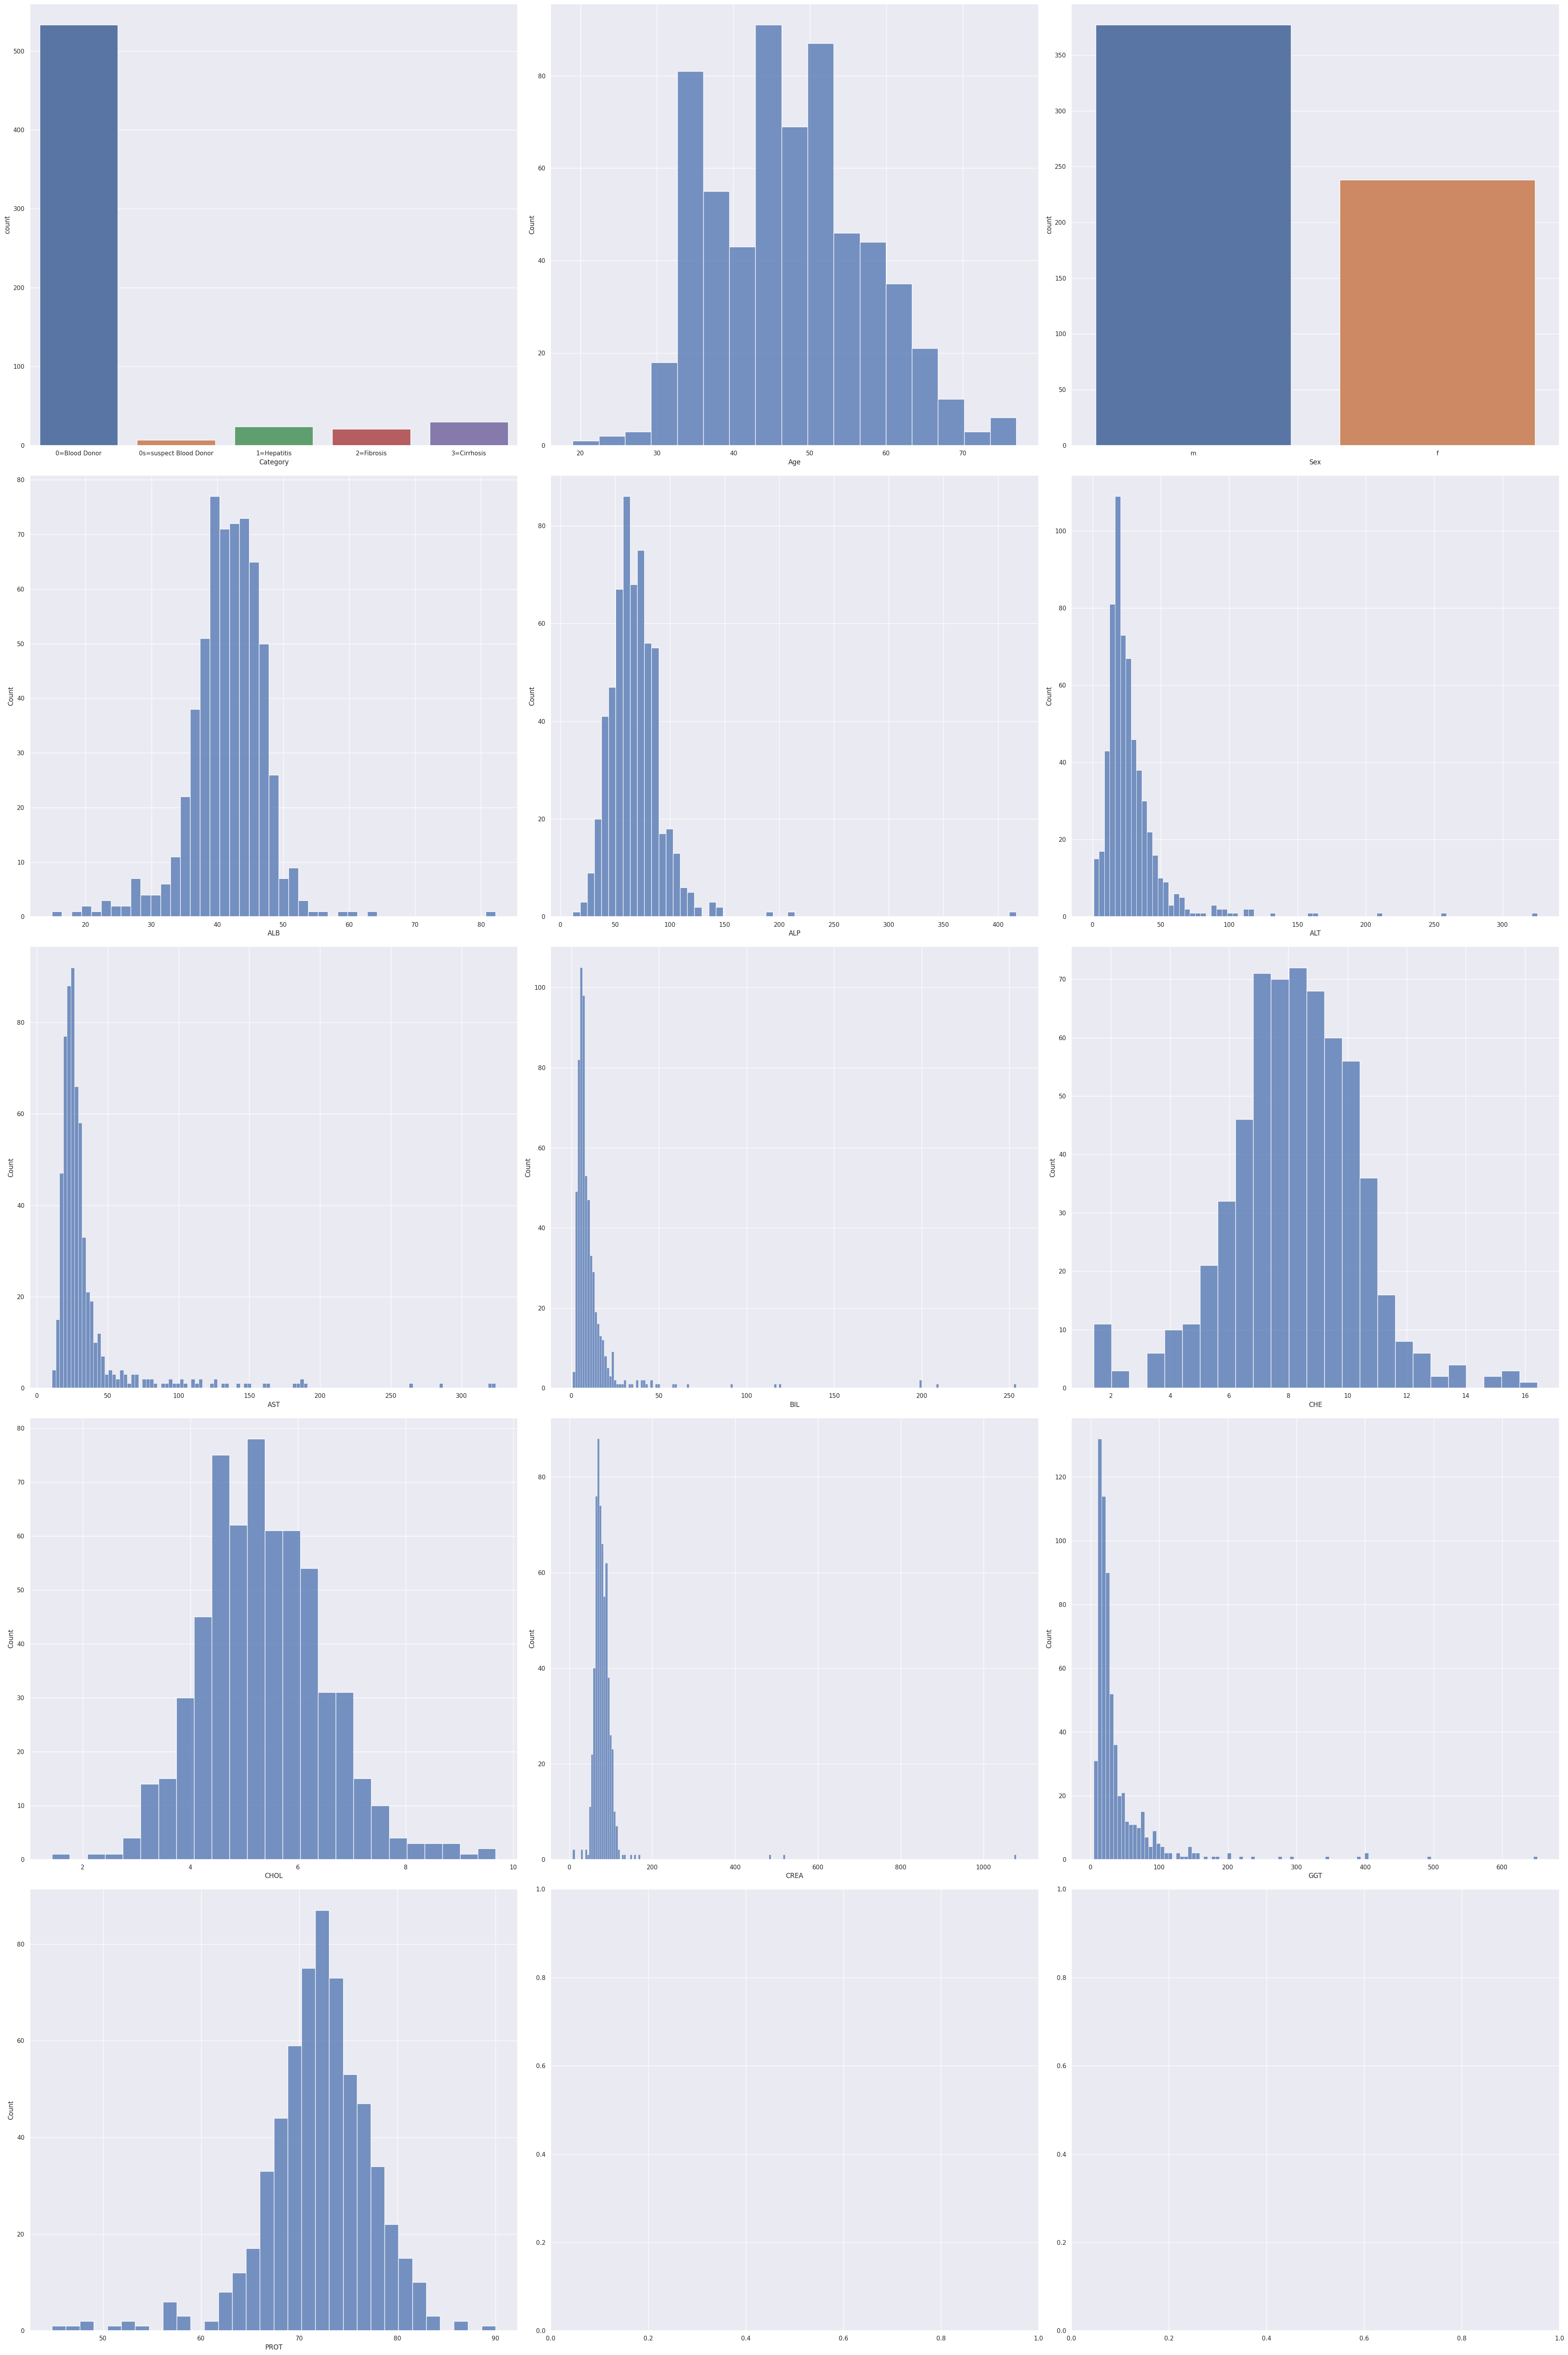

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(5,3,figsize=(40,60))

data_frame = pd.DataFrame(data)
data_frame.columns=data.columns
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=data_frame,ax=ax)
plt.tight_layout()

Podemos llegar a ver que las distribuciones que predominan sobre las variables son distribuciones normales y exponenciales. Aunque podemos llegar a ver algunas con distribuciones de poisson (esto debido a los valores extremos).

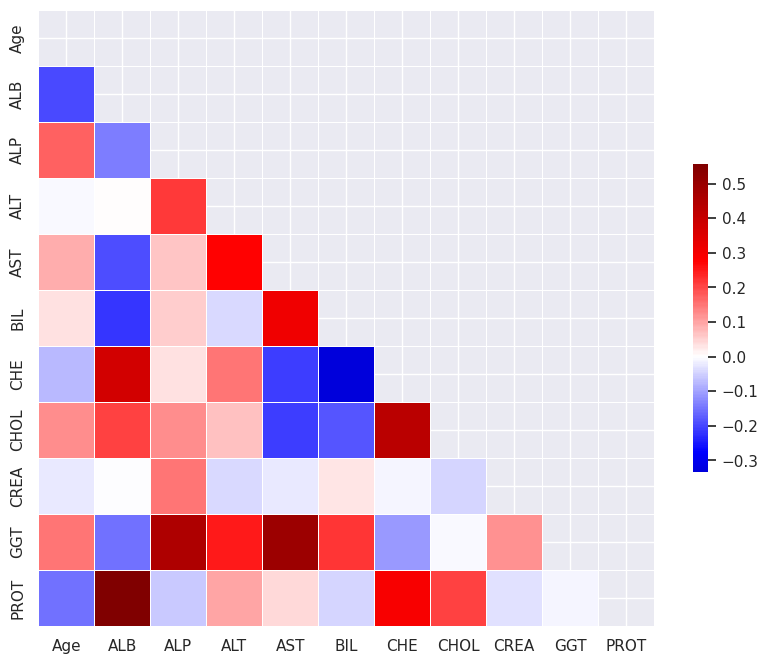

In [231]:
import numpy as np
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Viendo la matriz de correlaciones podemos ver que aunque haya correlaciones entre las variables. Estas no llegan a ser muy grandes (el valor más grande es un 0.5). Predominan correlaciones que rondan [-0.2 - 0.1]

Para hacer la clasificación en las cuatro clases primero fusionamos las dos variables categóricas que representan potenciales donantes (Blood Donor o suspect Blood Donor) y haremos codificaremos cada clase a un valor numerico. A su vez haremos one-hot encoding para nuestra variable categoríca Sex.

In [232]:
data['Category'] = data['Category'].replace(['0=Blood Donor', '0s=suspect Blood Donor'], "0")
data['Category'] = data['Category'].replace("1=Hepatitis", "1")
data['Category'] = data['Category'].replace("2=Fibrosis", "2")
data['Category'] = data['Category'].replace("3=Cirrhosis", "3")
data['Category'] = data['Category'].astype(int)
dummies1 = pd.get_dummies(data['Sex'], drop_first=True, prefix='Sex', prefix_sep='_') * 1
data = pd.concat([data,dummies1], axis=1)
data.drop(columns=['Sex'], inplace=True)
data.head()

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_m
0,0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,1
1,0,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,1
2,0,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,1
3,0,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,1
4,0,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,1


Miramos si hay valores perdidos y los si los hay les imputamos la media del atributo.

In [233]:
data.isna().sum().sort_values(ascending=False)

ALP         18
CHOL        10
ALB          1
ALT          1
PROT         1
Category     0
Age          0
AST          0
BIL          0
CHE          0
CREA         0
GGT          0
Sex_m        0
dtype: int64

In [234]:
data["ALP"].fillna(data["ALP"].mean(), inplace=True)
data["CHOL"].fillna(data["CHOL"].mean(), inplace=True)
data["ALB"].fillna(data["ALB"].mean(), inplace=True)
data["ALT"].fillna(data["ALT"].mean(), inplace=True)
data["PROT"].fillna(data["PROT"].mean(), inplace=True)
data.isna().sum().sort_values(ascending=False)

Category    0
Age         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
Sex_m       0
dtype: int64

**Partición de datos con estratificación**

In [235]:
from sklearn.model_selection import train_test_split
y = data["Category"]
X = data.drop("Category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X.head()
y_test.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_m
0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,1
1,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,1
2,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,1
3,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,1
4,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,1


80     0
236    0
480    0
243    0
339    0
Name: Category, dtype: int64

**Estandarización**

Debido a que tenemos tanto variables con una distribución normal y exponenciales. Haremos un estandarizado lineal y un estandarizado Yeo-Johnson respectivamente.

In [236]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#variables con distribución exponencial y
c =["ALT","AST","BIL","GGT"]

columns_to_standardize = X_train.iloc[:, :11].copy()
columns_to_standardize_test = X_test.iloc[:, :11].copy()
# Estandarizamos las variables llegan a tener una distribución normal.
scaler = StandardScaler()
columns_to_standardize[columns_to_standardize.columns.difference(c)] = scaler.fit_transform(columns_to_standardize[columns_to_standardize.columns.difference(c)])
columns_to_standardize_test[columns_to_standardize_test.columns.difference(c)] = scaler.fit_transform(columns_to_standardize_test[columns_to_standardize_test.columns.difference(c)])

#Las variables exponenciales tendrán una transformación yeo-johnson
from sklearn.preprocessing import PowerTransformer


box_cox_power = PowerTransformer(method='yeo-johnson')
columns_to_standardize[c]= box_cox_power.fit_transform(columns_to_standardize[c])
columns_to_standardize_test[c]= box_cox_power.fit_transform(columns_to_standardize_test[c])


# Reemplaza las primeras 11 columnas en X_train con las columnas estandarizadas
X_train.iloc[:, :11] = columns_to_standardize
X_test.iloc[:, :11] = columns_to_standardize_test

## **Apartado B: Reducción de dimensionalidad**

Vamos a aplicar un método de reducción de dimensionalidad a los datos de entrenamiento y comentaremos lo que se puede apreciar en la visualización.

In [237]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

print(pca.explained_variance_ratio_)
print()
print(pca.explained_variance_ratio_.cumsum())

[0.20455197 0.17835225 0.13614828 0.09821906 0.08581515 0.06452164
 0.05779602 0.04886523 0.04295384 0.0378704  0.03017405 0.01473212]

[0.20455197 0.38290422 0.5190525  0.61727155 0.70308671 0.76760834
 0.82540436 0.87426959 0.91722343 0.95509383 0.98526788 1.        ]


Aplicamos PCA y observamos que con 7 componentes ya obtenemos más de un 80% de varianza acumulada, el cual es un valor estándard comúnmente utilizado. El motivo por el cual necesitamos tantos componentes para alcanzar este valor es la presencia de una gran cantidad de atributos que definen nuestros datos.

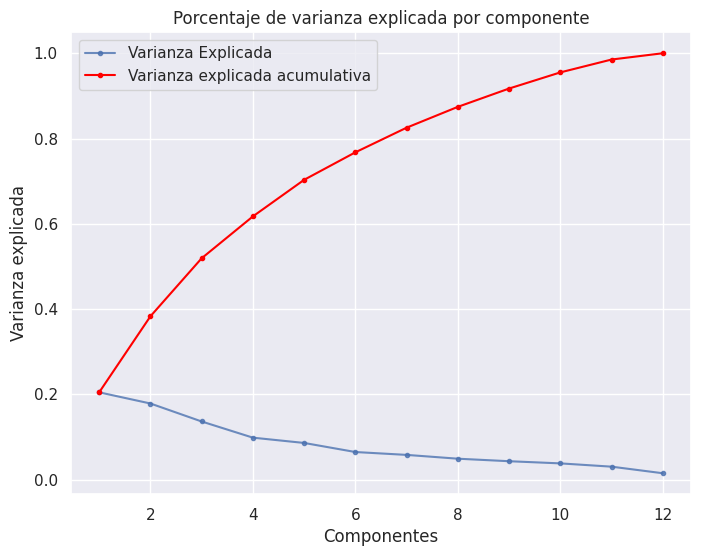

In [238]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_ , alpha=0.8, marker='.',
         label="Varianza Explicada");

y_label = plt.ylabel('Varianza explicada');
x_label = plt.xlabel('Componentes');

plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red', marker='.',
         label="Varianza explicada acumulativa");

plt.legend();
plt.title('Porcentaje de varianza explicada por componente');

En este gráfico podemos ver de manera ilustrada la evolución tanto de la varianza que aporta cada componente como de la varianza acumulada conseguida a medida que añadimos componentes.

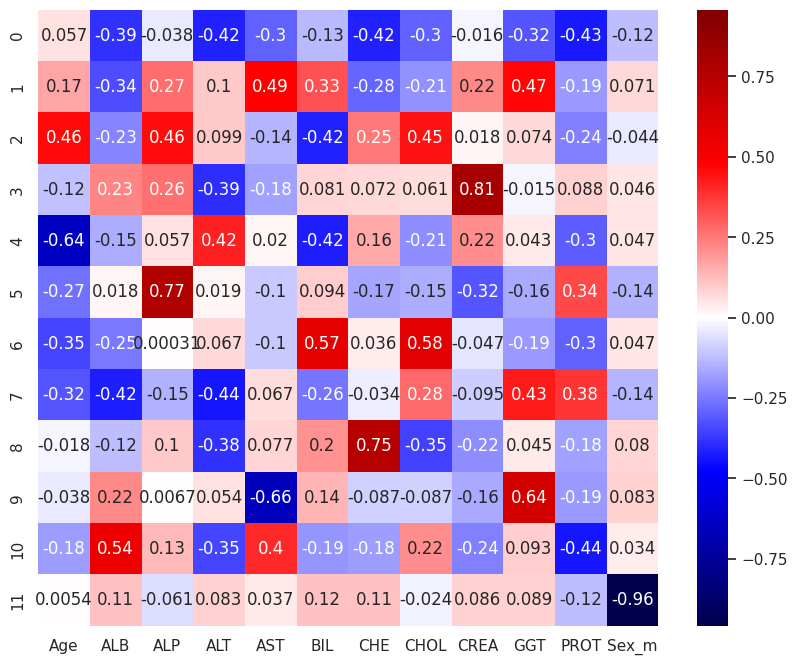

In [239]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(pca.components_, cmap='seismic',
            xticklabels=X_train.columns,
            vmin=-np.max(np.abs(pca.components_)),
            vmax=np.max(np.abs(pca.components_)),
            annot=True);

En esta imagen vemos los pesos que otorga cada una de las componentes a los distintos atributos de nuestro conjunto de datos.

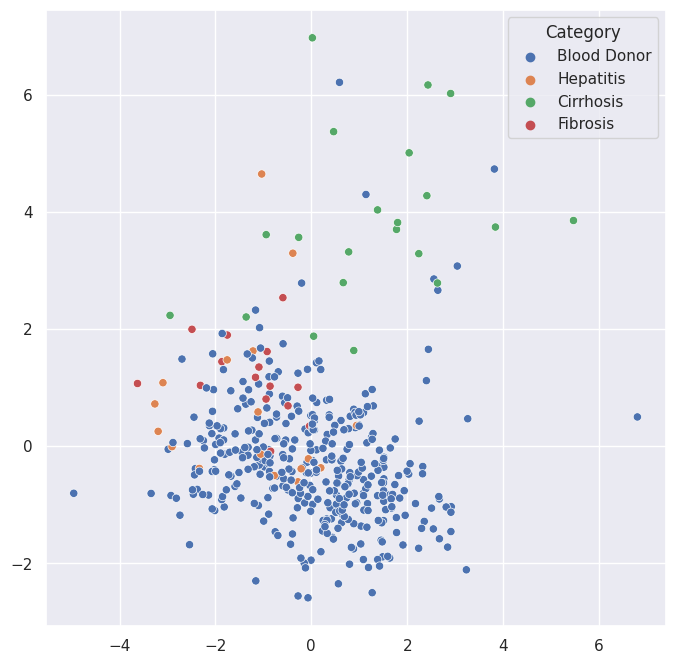

In [240]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8));

# Mapeamos y_train para hacer la visualización con los nombres
category_mapping = {0: 'Blood Donor', 1: 'Hepatitis', 2: 'Fibrosis', 3: 'Cirrhosis'}
y_train_mapped = y_train.map(lambda x: category_mapping.get(x))

sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train_mapped);

Aunque hayamos necesitado 7 componentes para obtener un buen nivel de varianza acumulada, podemos observar en la gráfica una cierta separación de los datos aún habiéndolos representado en solo 2 dimensiones.

Vemos una agrupación de _Blood Donor_ en la parte inferior izquierda, pero aún así nos estamos perdiendo información que nos la pueden proporcionar los otros componentes que no están representados en la gráfica. Vamos a visualizar ahora los datos añadiendo una componente más a la gráfica.

In [241]:
import plotly.express as px

fig = px.scatter_3d(X_train, x=X_trans[:,0], y=X_trans[:,1], z=X_trans[:,3], color=y_train_mapped)
fig.show();

Con la tercer componente añadida podemos ver con un poco más de claridad la distinción entre los rangos de la variable objetivo, pudiendo llegar a diferenciar mejor los individuos dentro del núbulo de puntos de _Blood Donor_.

Esta tercer componente nos está aportando un 12% de varianza extra, llegando a alcanzar un 50% de varianza acumulada.

Aún así tenemos una gran aglomeración de puntos de _Blood Donor_ los cuales apreciaríamos mejor si añadiéramos más dimensiones a nuestra gráfica.

## **Apartado C: Naïve Bayes**

A continuación haremos Naive Bayes con los datos ya transformados. Primeramente estableceremos el entorno.

In [242]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [243]:
gnb = GaussianNB()
accuracy = np.mean(cross_val_score(gnb,X_train,y_train,cv=10))
print("Acierto medio:",accuracy)

Acierto medio: 0.9279069767441861


Podemos ver que el acierto con el conjunto de entrenamiento es cercano al 0.9. Por lo tanto, a primeras vemos que es un modelo relativamente bueno y generaliza correctamente. Para tener más información, repetiremos la prueba sobre el conjunto de test.

In [244]:
gnb_model =  GaussianNB().fit(X_train,y_train)
prediction =gnb_model.predict(X_test)
Accuracy_NB = accuracy_score(y_test, prediction)
print("Acierto del Naive Bayes aplicado al conjunto de test:", Accuracy_NB)

Acierto del Naive Bayes aplicado al conjunto de test: 0.9513513513513514


Prediciendo el conjunto de test hemos observado que tenemos un acierto superior al conjunto de entrenamiento (pero este incremento no es substancial), esto nos puede dar una idea de que el modelo no ha llegado a especializarse en exceso haciendo el entrenamiento con su respectivo conjunto. A continuación, para profundizar sobre el acierto individual de cada categoría en la variable objetivo, veremos el estudio de clasificación.

In [245]:
print("Informe de Clasificación")
print(classification_report(prediction, y_test,target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.98      0.99      0.98       162
   Hepatitis       0.57      0.67      0.62         6
    Fibrosis       0.83      0.56      0.67         9
   Cirrhosis       0.78      0.88      0.82         8

    accuracy                           0.95       185
   macro avg       0.79      0.77      0.77       185
weighted avg       0.95      0.95      0.95       185



Como podemos ver, aunque tenga un acierto medio muy bueno. Debido a los grandes desbalances del tipo de Categoría (en nuestro dataset, BloodDonor tiene 540 instancias y, en cambio, unas 70 instancias del resto de tipos) hace que la precisión de Hepatitis, Fibrosis y Cirrosis sea mucho menor comparado con BloodDonor. Una posible solución sería aumentar el muestreo y tener más ejemplares de estos tipos.
Para tener una mejor visualización, haremos uso la matriz de confusión.

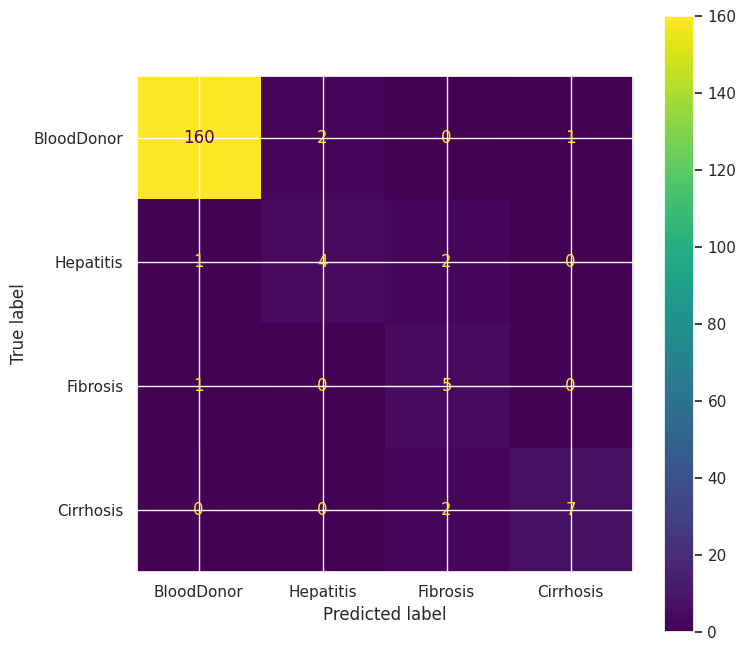

In [246]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Como podemos ver, el modelo no llega a saber una diferencia exacta entre BloodDonor, Hepatitis y Fibrosis (el modelo, cuando intenta predecir los valores de Hepatitis, los confunde con los otros 2 valores mencionados). En cambio, el modelo ya llega a ver diferencias claras en los casos de Fibrosis y no los confunde con Hepatitis ni Cirrosis. De la misma manera, el modelo ya ve diferencias también con BloodDonor y Hepatitis.

## **Apartado D: Discriminante Lineal**

In [247]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

lda = LinearDiscriminantAnalysis()
print("Acierto medio de LDA con el conjunto de entrenamiento:",np.mean(cross_val_score(lda,X_train,y_train,cv=10)))

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
print("Informe de Clasificación")
print(classification_report(lda.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

Acierto medio de LDA con el conjunto de entrenamiento: 0.9441860465116279
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.99      0.96      0.98       168
   Hepatitis       0.57      0.67      0.62         6
    Fibrosis       0.33      0.50      0.40         4
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.95       185
   macro avg       0.67      0.78      0.72       185
weighted avg       0.96      0.95      0.95       185



Vemos que el LDA, tiene una media de precision de 0.944. Esto nos permite ver que el modelo generaliza bastante bien y por lo tanto a priori parece un buen clasificador para nuestros datos, admeás vemos que no se sobreespecializa, ya que en el conjunto de test obtenemos una preisión del 0.95. El problema es que algunas de las classes tienen una precisión muy baja, esto será un problema si en lugar de ser positivas en la enfermedad, son positivas en BloodDonor, ya que corremos el peligro de dar por bueno a un donante que en realidad tiene una enfermedad.

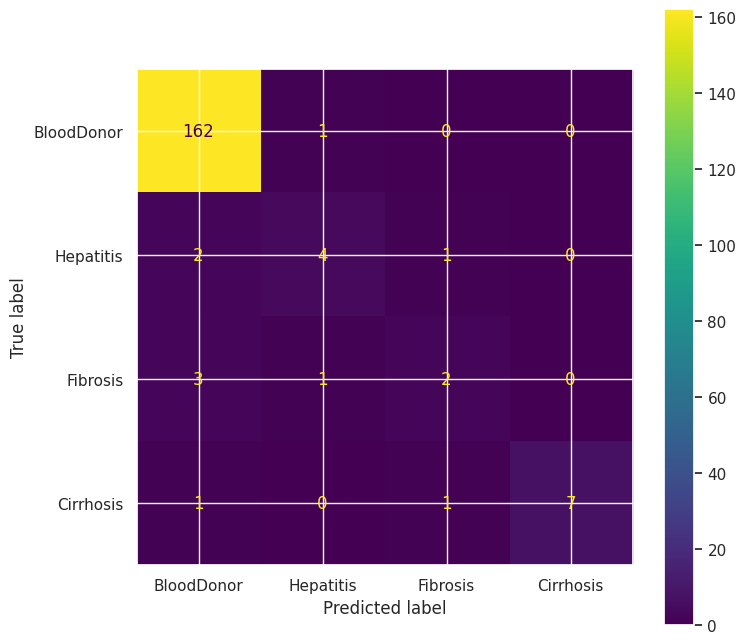

In [248]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, X_test,y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

En la matriz de confusión podemos ver algunas cosas interesantes. En primer lugar, como podemos ver, la hipotesis planteada anteriormente se confirma. Es decir, vemos que por ejemplo la Fibrosis (que es la clase con menor precision) se esta clasificando en su mayoría a Blood Donor, cosa que es un grave problema. Además no solo eso sinó que pasa lo mismo con las otras 2 enfermedades, aunque con la hepatitis es un poco peor que con la cirrhosis. Pero en el caso de que queramos usar este clasificador esto puede ser muy peligroso.

In [249]:
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

lr = LogisticRegression(max_iter=10000, solver="liblinear")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

print("Informe de Clasificación")
print(classification_report(lr_gs.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']})

,params,mean_test_score,rank_test_score
29,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.937,1
23,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.937,1
24,"{'C': 3.981071705534969, 'penalty': 'l1'}",0.937,1
25,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.937,1
31,"{'C': 31.622776601683793, 'penalty': 'l2'}",0.937,1


Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       1.00      0.96      0.98       169
   Hepatitis       0.57      1.00      0.73         4
    Fibrosis       0.50      0.60      0.55         5
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.96       185
   macro avg       0.71      0.89      0.78       185
weighted avg       0.97      0.96      0.96       185



Vemos que la regresión logistíca también funciona bastante bien, ya que al hacer el grid search obtenemos un 0.937 de precision media en el ranking 1. Además, generaliza muy buen ya que en el test obtenemos un 0.96 de precisión.

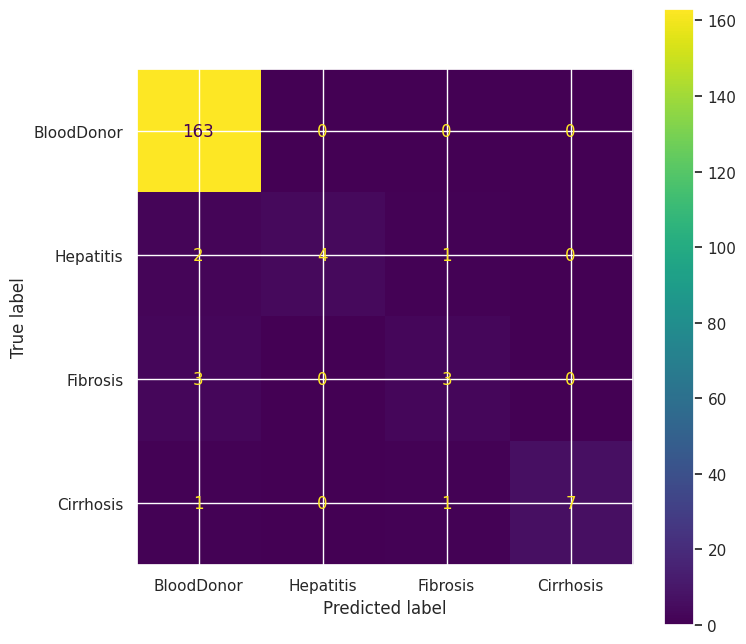

In [250]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Esta matriz es muy similar a la anterior y las confusiones son mas o menos las mismas, también es un peligro usar este clasificador ya que da por donante sin enfermedades, a gente que tiene enfermedades, sobre todo fibrosis.

Como conclusión y respondiendo a la pregunta del enunciado. Aunque Naive Bayes es el modelo con peor generalización de los tres modelos (0.928 vs 0.944 del LDA y vs 0.937 de la regresión logística), parece que es el mejor modelo a usar, ya que es el que tiene menos confusión entre gente que padece alguna enfermedad y gente que puede ser donante. Lo que nos pasará si usamos el Naive Bayes es que gente que puede ser donante diremos que no lo puede ser, pero es preferible eso a que gente que no puede ser donante lo sea.

## **Apartado E: Vicinal Risk Minimization**

La minimización de riesgos vecinales (Vicinal Risk Minimization) es un enfoque alternativo a la minimización del riesgo (en clase hablamos sobre la minimización empírica del riesgo) que establece que podemos abordar el aprendizaje utilizando una estimación de la densidad alrededor de los ejemplos. Esto puede verse como una técnica de aumento de datos (básicamente inventamos datos). Suponiendo que la densidad alrededor de un ejemplo es gaussiana, podemos añadir nuevos ejemplos a nuestro conjunto de datos agregándoles ruido gaussiano.

* Vamos a muestrear los datos de entrenamiento con reemplazo 500 y 1000 ejemplos de las tres clases minoritarias y agregaremos a cada uno ruido gaussiano con varianza 0.1 y 0.01 (tendremos un total de cuatro conjuntos de datos).

* Ajustaremos un discriminante lineal (LDA) y una regresión logística a estos conjuntos de datos.

In [251]:
import numpy as np
from sklearn.utils import resample

clases_minoritarias = [1, 2, 3]
indices_clase_minoritaria = np.isin(y_train, clases_minoritarias)

muestra_datos_500, y_train_500 = resample(X_train[indices_clase_minoritaria], y_train[indices_clase_minoritaria], n_samples=500, replace=True, random_state=0)

muestra_datos_1000, y_train_1000 = resample(X_train[indices_clase_minoritaria], y_train[indices_clase_minoritaria], n_samples=1000, replace=True, random_state=0)

ruido_01_500 = np.random.normal(0, 0.1, muestra_datos_500.shape)
muestra_datos_500_ruido_01 = muestra_datos_500 + ruido_01_500

ruido_001_500 = np.random.normal(0, 0.01, muestra_datos_500.shape)
muestra_datos_500_ruido_001 = muestra_datos_500 + ruido_001_500

ruido_01_1000 = np.random.normal(0, 0.1, muestra_datos_1000.shape)
muestra_datos_1000_ruido_01 = muestra_datos_1000 + ruido_01_1000

ruido_001_1000 = np.random.normal(0, 0.01, muestra_datos_1000.shape)
muestra_datos_1000_ruido_001 = muestra_datos_1000 + ruido_001_1000

X_train_0 = pd.concat([X_train, muestra_datos_500_ruido_01])
X_train_1 = pd.concat([X_train, muestra_datos_500_ruido_001])
X_train_2 = pd.concat([X_train, muestra_datos_1000_ruido_01])
X_train_3 = pd.concat([X_train, muestra_datos_1000_ruido_001])

y_train_0 = pd.concat([y_train, y_train_500])
y_train_1 = pd.concat([y_train, y_train_1000])

Acierto de LDA aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.1: 0.8526881720430106
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.95      0.99      0.97       156
   Hepatitis       0.71      0.45      0.56        11
    Fibrosis       1.00      0.55      0.71        11
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.94       185
   macro avg       0.86      0.75      0.78       185
weighted avg       0.93      0.94      0.93       185



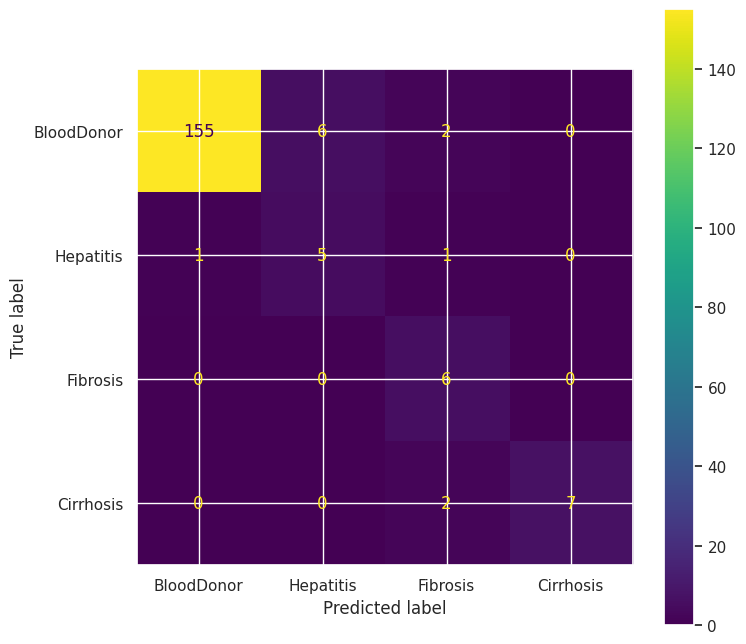

In [252]:
lda = LinearDiscriminantAnalysis()
print("Acierto de LDA aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.1:",np.mean(cross_val_score(lda,X_train_0,y_train_0,cv=10)))

lda = LinearDiscriminantAnalysis().fit(X_train_0, y_train_0)

print("Informe de Clasificación")
print(classification_report(lda.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Del informe de clasificación podemos sacar las siguientes conclusiones para cada clase:
* **BloodDonor:** Obtenemos una altra precisión y recall, lo que indica un buen rendimiento para esta clase.
* **Hepatitis:** La precisión es baja comparada con el recall, lo que sugiere que el modelo confunde otras clases con Hepatitis.

* **Fibrosis:** Tiene un perfecto recall pero una precisión moderada, implicando que identifica todos los casos de Fibrosis pero también clasifica erróneamente otros casos como Fibrosis.

* **Cirrhosis:** Tiene una alta precisión pero un recall más bajo, indicando que cuando predice Cirrosis generalmente es correcto, pero se pierden algunos casos reales.


Sobre la matriz de confusión vemos como por ejemplo, el modelo predijo correctamente 155 casos como donantes de sangre pero confundió algunos casos de _Hepatitis_, _Fibrosis_ y _Cirrhosis_ como donantes de sangre (falsos positivos para la clase _BloodDonor_).

,params,mean_test_score,rank_test_score
41,"{'C': 1000.0, 'penalty': 'l2'}",0.834,1
39,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.834,1
38,"{'C': 501.18723362727246, 'penalty': 'l1'}",0.834,1
37,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.834,1
36,"{'C': 251.18864315095772, 'penalty': 'l1'}",0.834,1


Acierto de la regresión logística aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.1: 0.9297297297297298
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.95      0.99      0.97       156
   Hepatitis       0.57      0.36      0.44        11
    Fibrosis       1.00      0.60      0.75        10
   Cirrhosis       0.78      0.88      0.82         8

    accuracy                           0.93       185
   macro avg       0.83      0.71      0.75       185
weighted avg       0.92      0.93      0.92       185



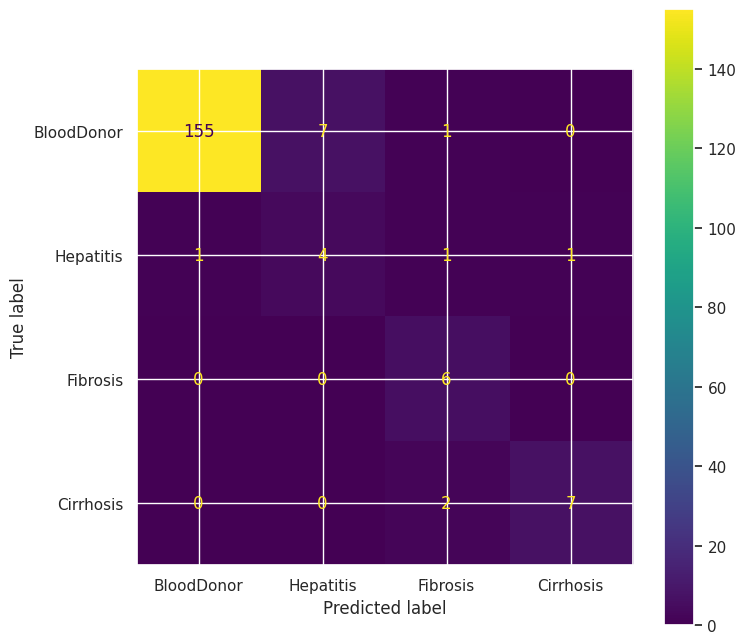

In [253]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_0, y_train_0);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

prediction =lr_gs.predict(X_test)
Accuracy_LR = accuracy_score(y_test, prediction)
print("Acierto de la regresión logística aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.1:", Accuracy_LR)

print("Informe de Clasificación")
print(classification_report(lr_gs.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Ahrora usando el modelo de Regresión Lineal vemos como hay algunas diferencias respecto el caso anterior con LDA. Las principales diferencias que vemos son:

* **Fibrosis:** A diferencia del caso anterior, ahora obtenemos una precisión del 67% cuando antes teníamos un 100%, mientras que el recall se mantiene en un valor parecido al de antes.

* **Cirrhosis:** La precisión se mantiene muy parecida mientras que el recall baja a un 64%, cuando antes teníamos un 100%.

Acierto de LDA aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.01: 0.856989247311828
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.95      0.99      0.97       156
   Hepatitis       0.71      0.45      0.56        11
    Fibrosis       1.00      0.55      0.71        11
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.94       185
   macro avg       0.86      0.75      0.78       185
weighted avg       0.93      0.94      0.93       185



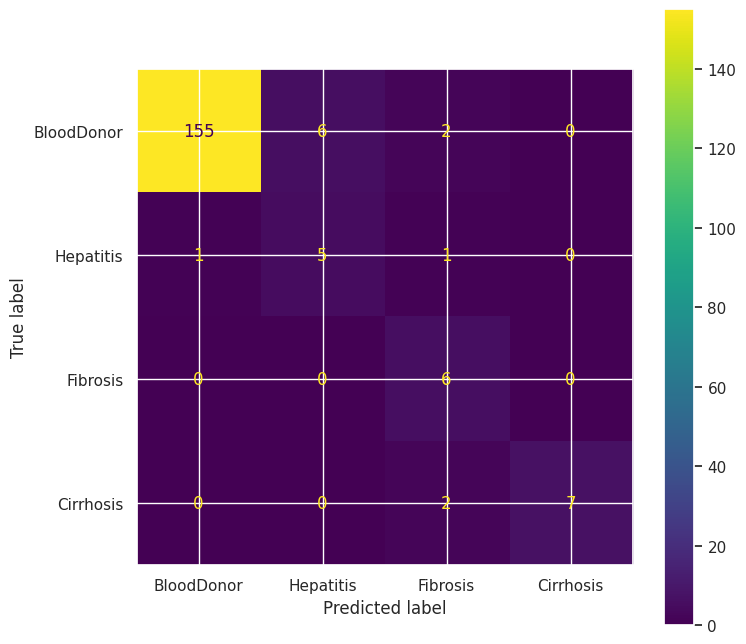

In [254]:
lda = LinearDiscriminantAnalysis()
print("Acierto de LDA aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.01:",np.mean(cross_val_score(lda,X_train_1,y_train_0,cv=10)))

lda = LinearDiscriminantAnalysis().fit(X_train_1, y_train_0)

print("Informe de Clasificación")
print(classification_report(lda.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Realizamos el mismo procedimiento para los diferentes conjuntos de datos y modelos, y al final del apartado haremos una explicación de los resultados y las conclusiones que hemos sacado.

,params,mean_test_score,rank_test_score
24,"{'C': 3.981071705534969, 'penalty': 'l1'}",0.831,1
22,"{'C': 1.9952623149688788, 'penalty': 'l1'}",0.831,1
34,"{'C': 125.89254117941663, 'penalty': 'l1'}",0.831,3
41,"{'C': 1000.0, 'penalty': 'l2'}",0.830,4
38,"{'C': 501.18723362727246, 'penalty': 'l1'}",0.830,4


Acierto de la regresión logística aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.01: 0.9297297297297298
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.94      0.99      0.97       155
   Hepatitis       0.71      0.42      0.53        12
    Fibrosis       1.00      0.55      0.71        11
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.93       185
   macro avg       0.86      0.74      0.77       185
weighted avg       0.93      0.93      0.92       185



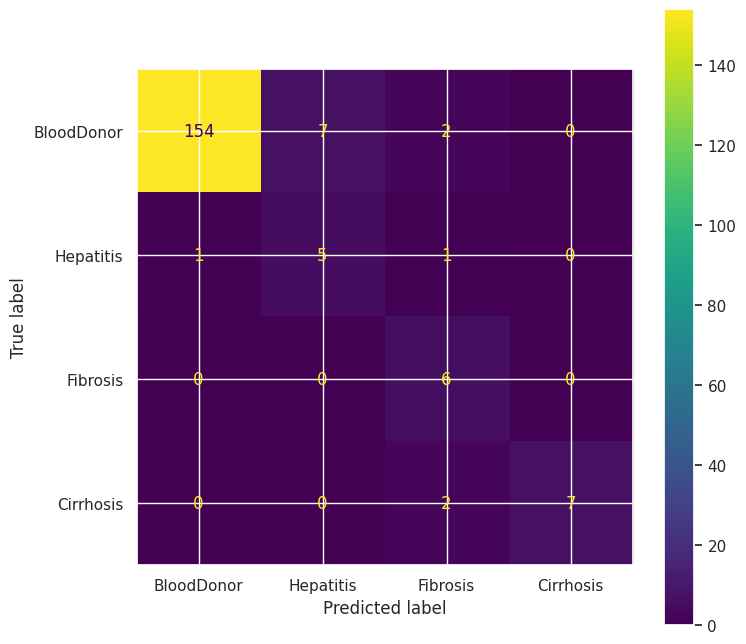

In [255]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_1, y_train_0);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

prediction =lr_gs.predict(X_test)
Accuracy_LR = accuracy_score(y_test, prediction)
print("Acierto de la regresión logística aplicado al conjunto de test con el caso 500 ejemplares de ruido 0.01:", Accuracy_LR)

print("Informe de Clasificación")
print(classification_report(lr_gs.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Acierto de LDA aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.1: 0.8153846153846154
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.91      0.99      0.95       150
   Hepatitis       0.71      0.31      0.43        16
    Fibrosis       1.00      0.50      0.67        12
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.90       185
   macro avg       0.85      0.70      0.73       185
weighted avg       0.90      0.90      0.89       185



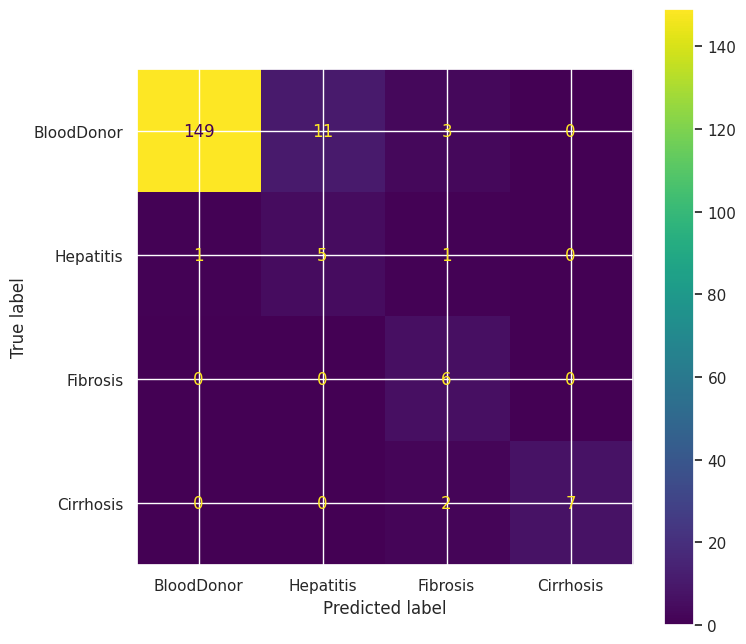

In [256]:
lda = LinearDiscriminantAnalysis()
print("Acierto de LDA aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.1:",np.mean(cross_val_score(lda,X_train_2,y_train_1,cv=10)))

lda = LinearDiscriminantAnalysis().fit(X_train_2, y_train_1)

print("Informe de Clasificación")
print(classification_report(lda.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

,params,mean_test_score,rank_test_score
9,"{'C': 0.015848931924611134, 'penalty': 'l2'}",0.805,1
13,"{'C': 0.0630957344480193, 'penalty': 'l2'}",0.803,2
40,"{'C': 1000.0, 'penalty': 'l1'}",0.802,3
34,"{'C': 125.89254117941663, 'penalty': 'l1'}",0.802,3
41,"{'C': 1000.0, 'penalty': 'l2'}",0.802,3


Acierto de la regresión logística aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.1: 0.8486486486486486
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.86      0.99      0.92       141
   Hepatitis       0.71      0.24      0.36        21
    Fibrosis       0.83      0.42      0.56        12
   Cirrhosis       0.78      0.64      0.70        11

    accuracy                           0.85       185
   macro avg       0.80      0.57      0.63       185
weighted avg       0.84      0.85      0.82       185



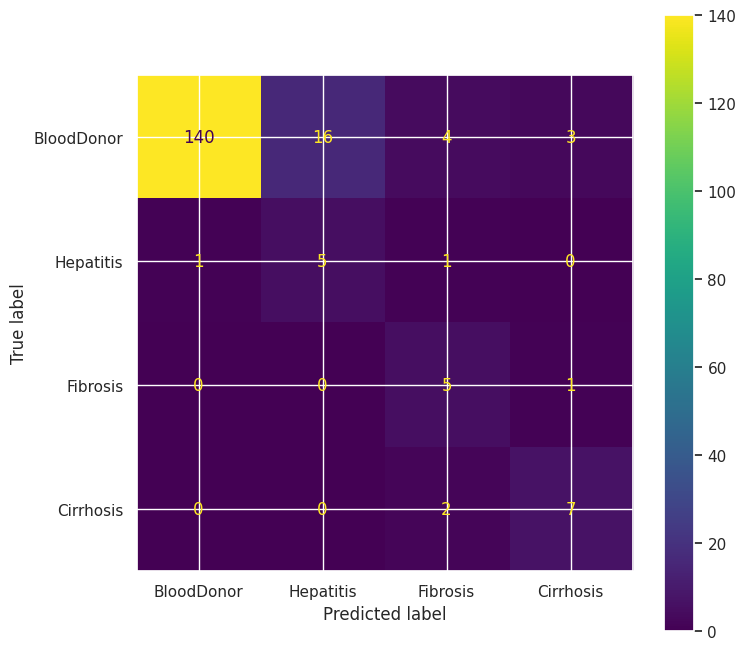

In [257]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_2, y_train_1);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

prediction =lr_gs.predict(X_test)
Accuracy_LR = accuracy_score(y_test, prediction)
print("Acierto de la regresión logística aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.1:", Accuracy_LR)

print("Informe de Clasificación")
print(classification_report(lr_gs.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Acierto de LDA aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.01: 0.8048951048951049
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.91      0.99      0.95       150
   Hepatitis       0.71      0.31      0.43        16
    Fibrosis       1.00      0.50      0.67        12
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.90       185
   macro avg       0.85      0.70      0.73       185
weighted avg       0.90      0.90      0.89       185



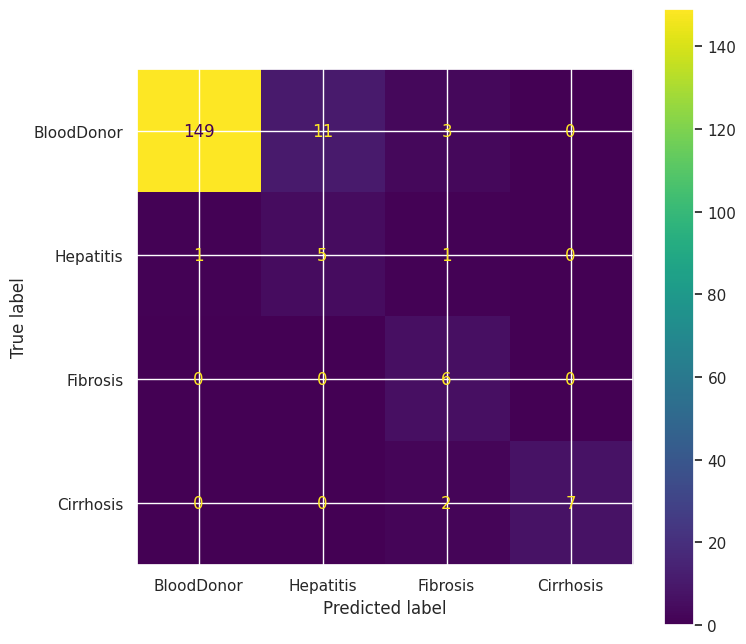

In [258]:
lda = LinearDiscriminantAnalysis()
print("Acierto de LDA aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.01:",np.mean(cross_val_score(lda,X_train_3,y_train_1,cv=10)))

lda = LinearDiscriminantAnalysis().fit(X_train_3, y_train_1)

print("Informe de Clasificación")
print(classification_report(lda.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

,params,mean_test_score,rank_test_score
38,"{'C': 501.18723362727246, 'penalty': 'l1'}",0.836,1
40,"{'C': 1000.0, 'penalty': 'l1'}",0.835,2
36,"{'C': 251.18864315095772, 'penalty': 'l1'}",0.834,3
34,"{'C': 125.89254117941663, 'penalty': 'l1'}",0.834,3
32,"{'C': 63.0957344480193, 'penalty': 'l1'}",0.832,5


Acierto de la regresión logística aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.01: 0.9081081081081082
Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.94      0.99      0.96       155
   Hepatitis       0.43      0.27      0.33        11
    Fibrosis       1.00      0.50      0.67        12
   Cirrhosis       0.67      0.86      0.75         7

    accuracy                           0.91       185
   macro avg       0.76      0.65      0.68       185
weighted avg       0.90      0.91      0.90       185



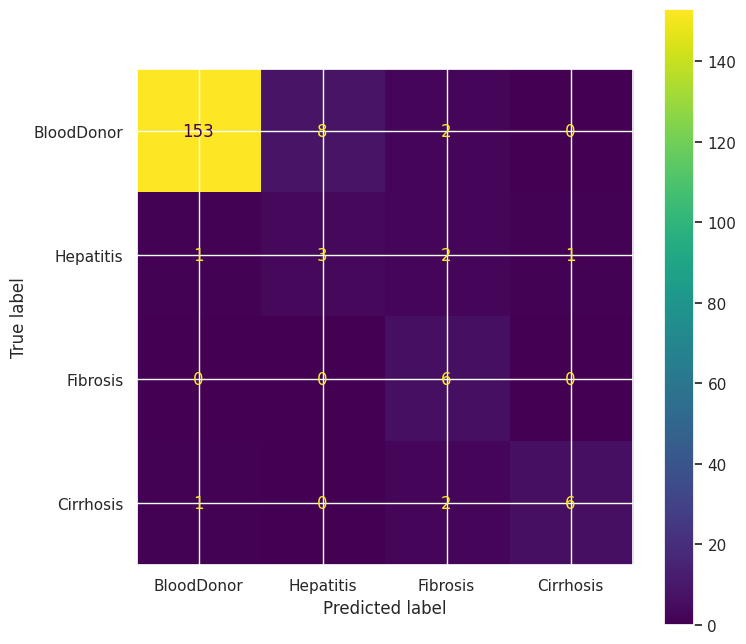

In [259]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_3, y_train_1);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

prediction =lr_gs.predict(X_test)
Accuracy_LR = accuracy_score(y_test, prediction)
print("Acierto de la regresión logística aplicado al conjunto de test con el caso 1000 ejemplares de ruido 0.01:", Accuracy_LR)

print("Informe de Clasificación")
print(classification_report(lr_gs.predict(X_test), y_test, target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

Observamos que cuantos más ejemplos tengamos de las clases originalmente minoritarias, más precisión obtenemos para su predicción. Podemos ver como los resultados son mejores cuando añadimos solo 500 muestras con ruido gausiano que 1000.

Creemos que el efecto de los datos adicionales en los clasificadores es que con el aumento de casos en los que las clases minoritarias pasan a ser las dominantes en los resultados, los modelos tienden a prestarles una atención mucho mayor en busca de una precisión global efectiva, dejando atrás su antigua tendencia de ignorarlas.
Podemos observar esto en la clase _BloodDonor_ y _Hepatitis_, donde antes clasificaba bien todas las instancias de _Hepatitis_ pero ahora confunde unas 10 instancias de _Hepatitis_ como _BloodDonor_.

Es importante notar que la variabilidad que aplicamos al ruido gaussiano que agregamos no tiene un efecto importante en los resultados; aun cuando utilizamos dos conjuntos distintos con métricas ligeramente diferentes, los resultados de precisión son los mismos.
Los únicos casos donde notamos una diferencia es en las clases _Hepatitis_ y _Cirrhosis_ cuando usamos el modelo de Linear Regression con variabilidad 0.01, que performan peor que su contraparte con Linear Regression y variabilidad 0.1.

## **Apartado F**
A continuación haremos la regresión logística con *class_weight* en *balanced*. Primero de todo importaremos todo lo necesario.

In [260]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Debido a que la regresión tiene otros tipos de hiperparametros, utilizaremos una busqueda de los mejores hiperparametros junto a restricción del tipo de *class_weight*.

In [261]:
lr = LogisticRegression(max_iter=10000, solver="liblinear",class_weight="balanced")
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train);

In [262]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.944,1
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.944,1
13,"{'C': 0.0630957344480193, 'penalty': 'l2'}",0.942,3
17,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.940,4
11,"{'C': 0.03162277660168379, 'penalty': 'l2'}",0.940,4


A primeras, vemos que el acierto medio del mejor modelo supera el 90% por lo cual llega a ser aceptable y mejor que el resto de modelos vistos hasta este momento. A continuación veremos el acierto sobre el conjunto de test para tener una mejor referencia de si el modelo se comporta bien.

In [263]:
prediction =lr_gs.predict(X_test)
Accuracy_LR = accuracy_score(y_test, prediction)
print("Acierto de la regresión logística aplicado al conjunto de test:", Accuracy_LR)

Acierto de la regresión logística aplicado al conjunto de test: 0.9621621621621622


Vemos que el acierto de la regresión logística es superior al del conjunto de entrenamiento, esto nos puede decir que el conjunto no ser ha especializado en exceso.

In [264]:
print("Informe de Clasificación")
print(classification_report(prediction, y_test,target_names=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"]))

Informe de Clasificación
              precision    recall  f1-score   support

  BloodDonor       0.98      0.99      0.99       161
   Hepatitis       0.71      0.71      0.71         7
    Fibrosis       1.00      0.60      0.75        10
   Cirrhosis       0.78      1.00      0.88         7

    accuracy                           0.96       185
   macro avg       0.87      0.83      0.83       185
weighted avg       0.96      0.96      0.96       185



Viendo el informe de clasificación. 3 de las 4 clases llegan a obtener un acierto medio aceptable (cabe resaltar que  modelo en una categoría llega a predecir de manera perfecta y en otro está solo por 2 centésimas pro debajo del 100% de precisión). El caso de hepatitis, en cambio, ha tenido un cambio significativo respecto a Naive Bayes, subiendo 11 centésimas respecto a este.

Por lo tanto, estamos llegando a ver que este modelo es superior que Naive Bayes y LDA. A su vez, vemos que este modelo tiene muchas similitudes con la regresión logística y LDA con 500 ejemplares introducidos metiendo ruido gausiano con varianza de 0.1 (el único target que llega a ser diferente es BloodDonor donde la regresión es superior).

Si comparamos las diferentes regresiones logísticas hechas, vemos que la regresión logística, con ruido de varianza 0.1 sobre 500 ejemplares, llega a tener el acierto de las clases minoritarias idéntico. Es decir, los cambios se llegan a ver con BloodDonor. En cambio, en las regresiones logísticas con ruido de varianza 0.01 debido a lo mencionado en el apartado anterior, podemos ver que la regresión logística *balanced* es superior.

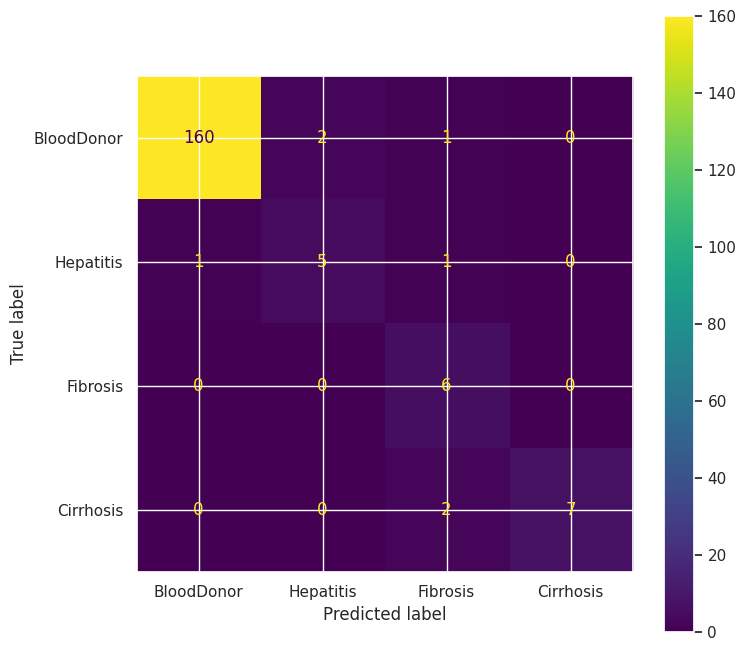

In [265]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=["BloodDonor", "Hepatitis", "Fibrosis","Cirrhosis"], ax=plt.subplot());

 Vemos que BloodDonor o bien tiene una precisión superior (frente a los modelos con ruido) o si es inferior, esta diferencia no llega a ser substancial (modelos iniciales de Naive Bayes, LDA y Regresión Logística). A su vez, con este método no vemos la reducción de precisión de la clase BloodDonor debido a la introducción de ruido. Podemos también resaltar que este modelo tiene la mejor precisión de las clases minoritarias junto a los modelos LDA con ruido y también el modelo de regresión Logística con ruido de 0.1 y 500 nuevos ejemplares.

Entonces podemos ver que esta opción nos llega a proporcionar una clara ventaja respecto al resto de modelos, principalmente al método. Todo esto es porque esta vez, en vez de utilizar métodos externos para intentar eliminar el desbalance de clases mediante la introducción de ruido. Hemos dicho que el modelo se base en este propio desbalance. Haciendo que las clases con muchos ejemplos lleguen a tener valores similares a como si no hubiéramos llegado a especificar la opción *balanced*, mientras que con las clases minoritarias se intentará una mejor predicción.